<a href="https://colab.research.google.com/github/harmanpreet93/reinforcement-learning/blob/master/BairdCounterExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Baird Counter Example

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [0]:
class BairdMDP():
    # class implementing MDP as per the question's requirement   
    def __init__(self):
        self.SOLID = 1
        self.DASH = 0
        self.NUM_OF_STATES = 7
        self.step_prob = 1/self.NUM_OF_STATES
    
    def pick_action(self):
        # pick action based in the probablity distribution
        action = np.random.binomial(1, self.step_prob)
        return action

    def step(self, action):
        if action == self.SOLID:
            next_state = 6
        elif action == self.DASH:
            next_state = np.random.choice(self.NUM_OF_STATES - 1)
        return next_state

In [0]:
class SemiGradientTD0():
    # Semi-Gradient TD(0) Off-policy implementation
    def __init__(self, bairdMDP, gamma=0.99, alpha=0.01):
        self.mdp = bairdMDP
        self.gamma = gamma
        self.alpha = alpha
        self.initialize_features_and_weights()

    def initialize_features_and_weights(self):
        self.weights = self.initialize_weights()
        self.features = self.get_feature_representation()

    def initialize_weights(self):
        return np.array([1,1,1,1,1,1,10,1], dtype=np.float32)

    def get_feature_representation(self):
        return np.array([[2, 0, 0, 0, 0, 0, 0, 1],
                        [0, 2, 0, 0, 0, 0, 0, 1],
                        [0, 0, 2, 0, 0, 0, 0, 1],
                        [0, 0, 0, 2, 0, 0, 0, 1],
                        [0, 0, 0, 0, 2, 0, 0, 1],
                        [0, 0, 0, 0, 0, 2, 0, 1],
                        [0, 0, 0, 0, 0, 0, 1, 2]], dtype=np.float32)
        
    def value(self, state):
        # W^T.X
        return np.dot(self.weights, self.features[state])

    def run_TD_algorithm(self, n_steps=1000):
        # Run TD(0) for desired number of steps
        current_state = np.random.choice(mdp.NUM_OF_STATES)
        step_weights = np.zeros((n_steps, len(self.weights)))
        values = np.zeros((n_steps)) 
        step = 0
        while step < n_steps:
            step_weights[step] = self.weights
            values[step] = self.value(current_state)
            action = self.mdp.pick_action()
            next_state = self.mdp.step(action)
            if action == self.mdp.DASH:
                rho = 0
            else:
                rho = 1/self.mdp.step_prob
            delta = self.gamma * self.value(next_state) - self.value(current_state)
            self.weights += self.alpha * rho * delta * self.features[current_state]
            current_state = next_state
            step += 1

        return step_weights, values


def plot_weights_graph(step_weights):
    # Plot weight graphs
    fig = plt.figure()
    caption = "Alpha=0.01, Gamma=0.99, Initial weights w=(1,1,1,1,1,1,10,1)"
    ax1 = fig.add_axes((0.1,0.2,0.8,0.7))
    ax1.set_title("Semi-gradient Off-policy TD(0)")
    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Weights')
    fig.text(.2,.1, caption)
    steps, num_weights = step_weights.shape
    for i in range(num_weights):
        ax1.plot(range(steps), step_weights[:,i], label="w{}".format(i+1))
    plt.legend();
    # resize the figure to match the aspect ratio of the Axes    
    fig.set_size_inches(7, 8, forward=True)
    plt.show()

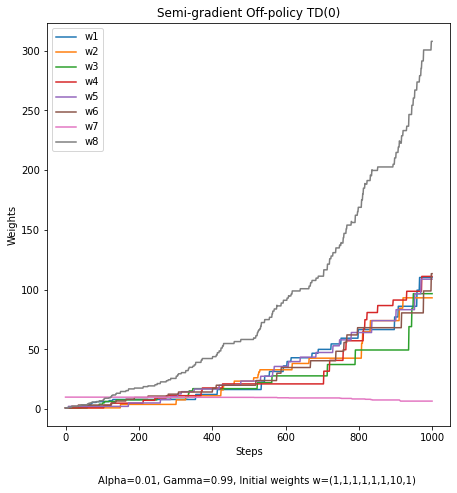

In [0]:
mdp = BairdMDP()
semiGradTD = SemiGradientTD0(mdp)
step_weights, values = semiGradTD.run_TD_algorithm(n_steps=1000)
plot_weights_graph(step_weights)

### Experiments on different seeds

In [0]:
seeds = [0, 10, 42, 55, 90]
weights_dict = {}

for seed in seeds:
    # set seed
    np.random.seed(seed)
    mdp = BairdMDP()
    semiGradTD = SemiGradientTD0(mdp)
    step_weights, values = semiGradTD.run_TD_algorithm(n_steps=1000)
    weights_dict[seed] = step_weights

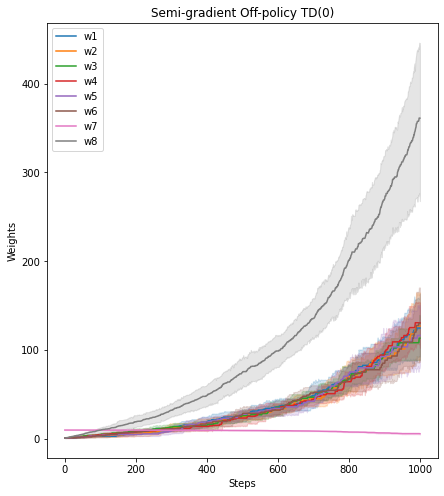

In [0]:
# plot variance
plt.figure(figsize=(7,8))
legend_label = []
steps, num_weights = step_weights.shape
for i in range(num_weights):
    w = []
    for seed in seeds:
        w.append(weights_dict[seed][:,i])
    df = pd.melt(pd.DataFrame(w))
    sns.lineplot(x='variable', y='value', data=df)
    legend_label.append('w{}'.format(i+1))

plt.xlabel("Steps")
plt.ylabel("Weights")
plt.title("Semi-gradient Off-policy TD(0)")
plt.legend(legend_label, loc='upper left');

### Observations  

This Baird’s counterexample demonstrates the divergence in semi-gradient based off-policy TD(0) method with linear-function approximation. We can see from the above plot how the weights fail to converge, and positively diverge. Off-policy is much harder with function approximation. Difficulty of off-policy learning is that the behavior policy  take the process to a distribution of states different from that which would be encountered under the target policy, yet the states might appear to be the similar due to function approximation. 

The risk of divergence arises whenever we combine three things - Function approximation, Boostraping and Off-policy learning. This combination, known as *Deadly Traid* is what has occured in our example.

